In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from IPython.display import Markdown
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
N_SEED = 19
TOP_K = 5
VERBOSE = 1
N_JOBS = 4
COLOR_MAP = "RdYlBu"
L_FONT = {
    "color": "darkblue",
    "size": 11
}
T_COLOR = "darkred"

np.random.seed(N_SEED)

In [3]:
dataset = pd.read_csv("../data/creditcard.csv")

## EDA

In [4]:
dataset.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [5]:
dataset.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
dataset.isnull().values.sum()

np.int64(0)

In [8]:
def show_corr(features, target):
    plt.figure(figsize=(19, 15))
    features.corrwith(target).plot.bar(color="purple", grid=True)
    ax = plt.gca()
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(T_COLOR)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(T_COLOR)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def show_corr_heatmap(data):
    corr = data.corr() * 100
    plt.figure(figsize=(20, 15))
    sns.heatmap(corr, annot=True, cmap=COLOR_MAP, fmt=".2f")
    ax = plt.gca()
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(T_COLOR)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(T_COLOR)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def plot_features(x, target):
    _, col = x.shape
    for i in range(col):
        plt.scatter(x[:, i], target, color="red", s=4,)
        plt.xlabel("X: {i}".format(i=i), fontdict=L_FONT)
        plt.ylabel("Target", fontdict=L_FONT)
        ax = plt.gca()
        ax.spines["bottom"].set_color(T_COLOR)
        ax.spines["top"].set_color(None)
        ax.spines["left"].set_color(T_COLOR)
        ax.spines["right"].set_color(None)
        ax.tick_params(axis="x", colors=T_COLOR)
        ax.tick_params(axis="y", colors=T_COLOR)
        plt.show();
        plt.hist(x[:, i], color="green")
        plt.xlabel("X: {i}".format(i=i), fontdict=L_FONT)
        plt.ylabel("Population", fontdict=L_FONT)
        ax = plt.gca()
        ax.spines["bottom"].set_color(T_COLOR)
        ax.spines["top"].set_color(None)
        ax.spines["left"].set_color(T_COLOR)
        ax.spines["right"].set_color(None)
        ax.tick_params(axis="x", colors=T_COLOR)
        ax.tick_params(axis="y", colors=T_COLOR)
        plt.show();


def plot_class_dist(target):
    unique, counts = np.unique(target, return_counts=True)
    plt.bar(unique, counts, color="darkblue",)
    plt.xlabel("Class", fontdict=L_FONT)
    plt.ylabel("Population", fontdict=L_FONT)
    ax = plt.gca()
    ax.set_xticks(ticks=unique, labels=unique)
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(None)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(None)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def plot_roc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr, color="#1ecbe1", label="AUC = %0.4f" % roc_auc,)
    plt.legend(loc = "lower right")
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("TPR", fontdict=L_FONT)
    plt.xlabel("FPR", fontdict=L_FONT)
    ax = plt.gca()
    ax.set_title("Receiver Operating Characteristic", fontdict={"color": "darkblue"})
    ax.spines["bottom"].set_color(T_COLOR)
    ax.spines["top"].set_color(None)
    ax.spines["left"].set_color(T_COLOR)
    ax.spines["right"].set_color(None)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();


def plot_classification(y_true, y_pred):
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred)
    sns.heatmap(
        (precision*100, recall*100, f1*100),
        annot=True, cmap=COLOR_MAP,
        fmt=".4f",
        yticklabels=("precision", "recall", "f1")
    )
    ax = plt.gca()
    ax.set_title("Classification Report", fontdict=L_FONT)
    ax.tick_params(axis="x", colors=T_COLOR)
    ax.tick_params(axis="y", colors=T_COLOR)
    plt.show();

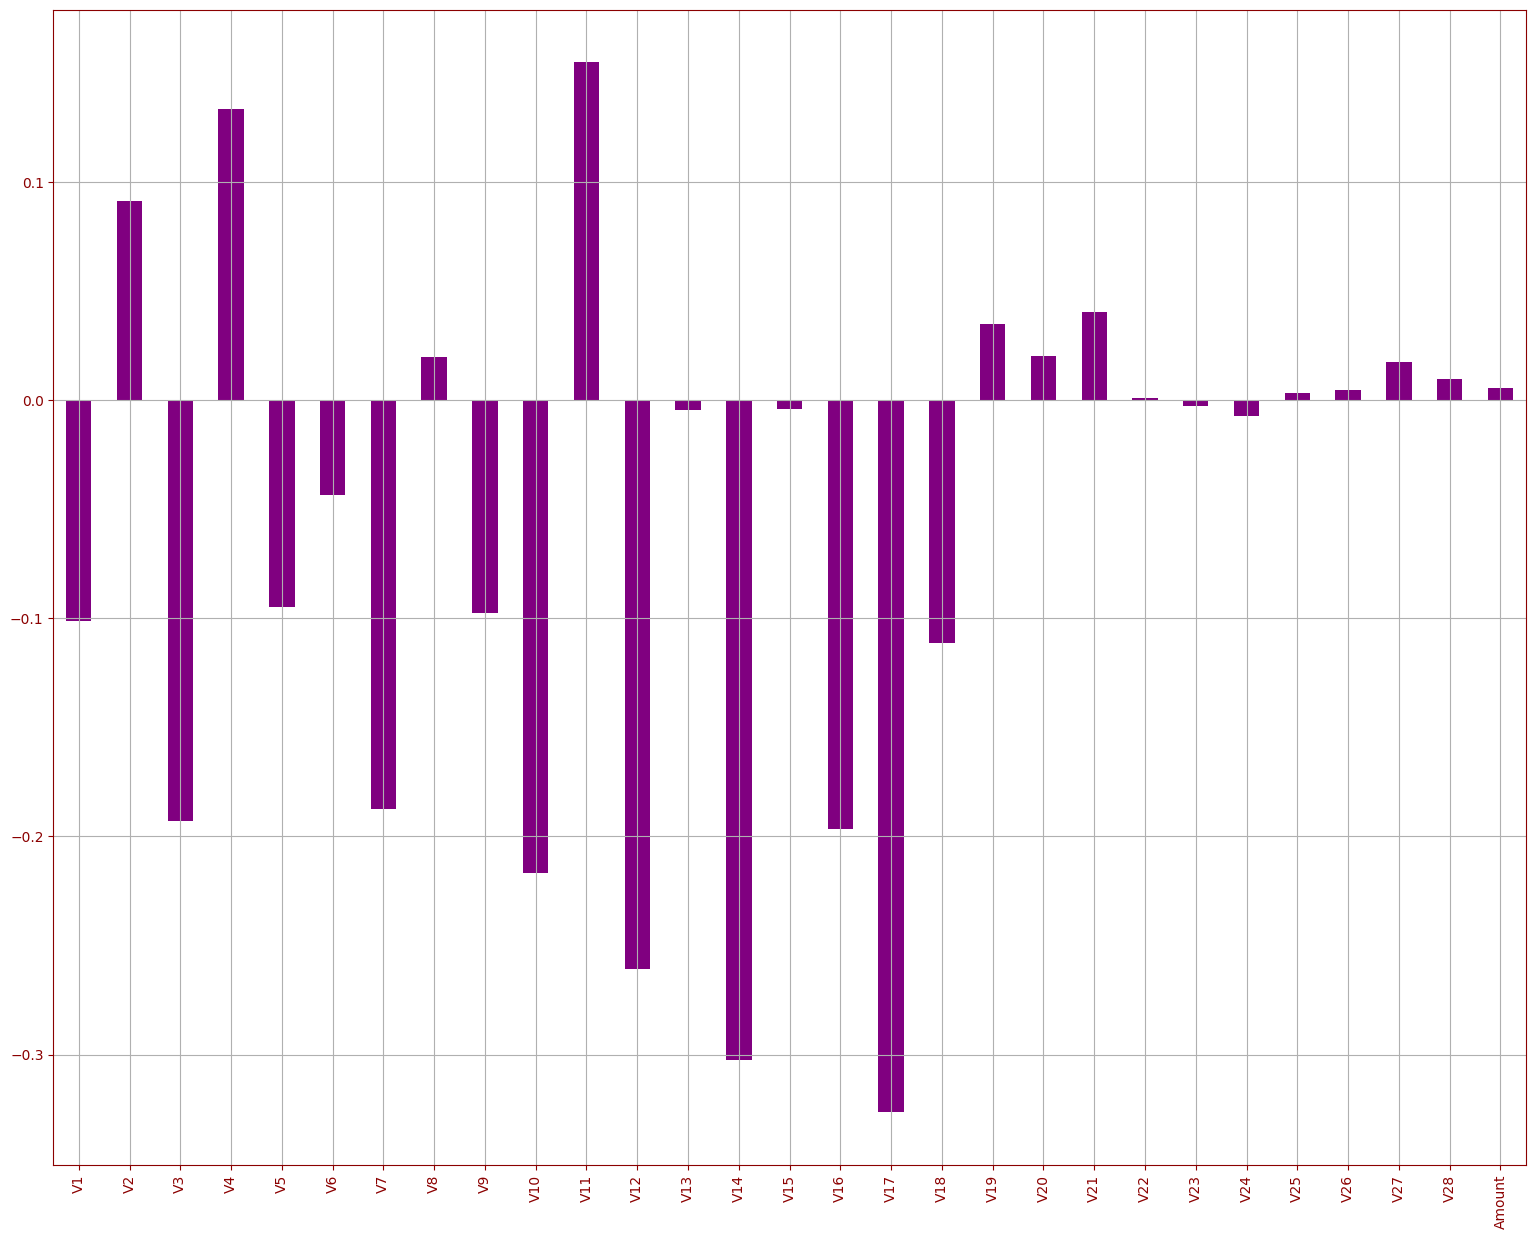

In [9]:
X_df = dataset.drop(columns=["Class", "Time"], axis=1)
y_df = dataset["Class"]
show_corr(X_df, y_df)

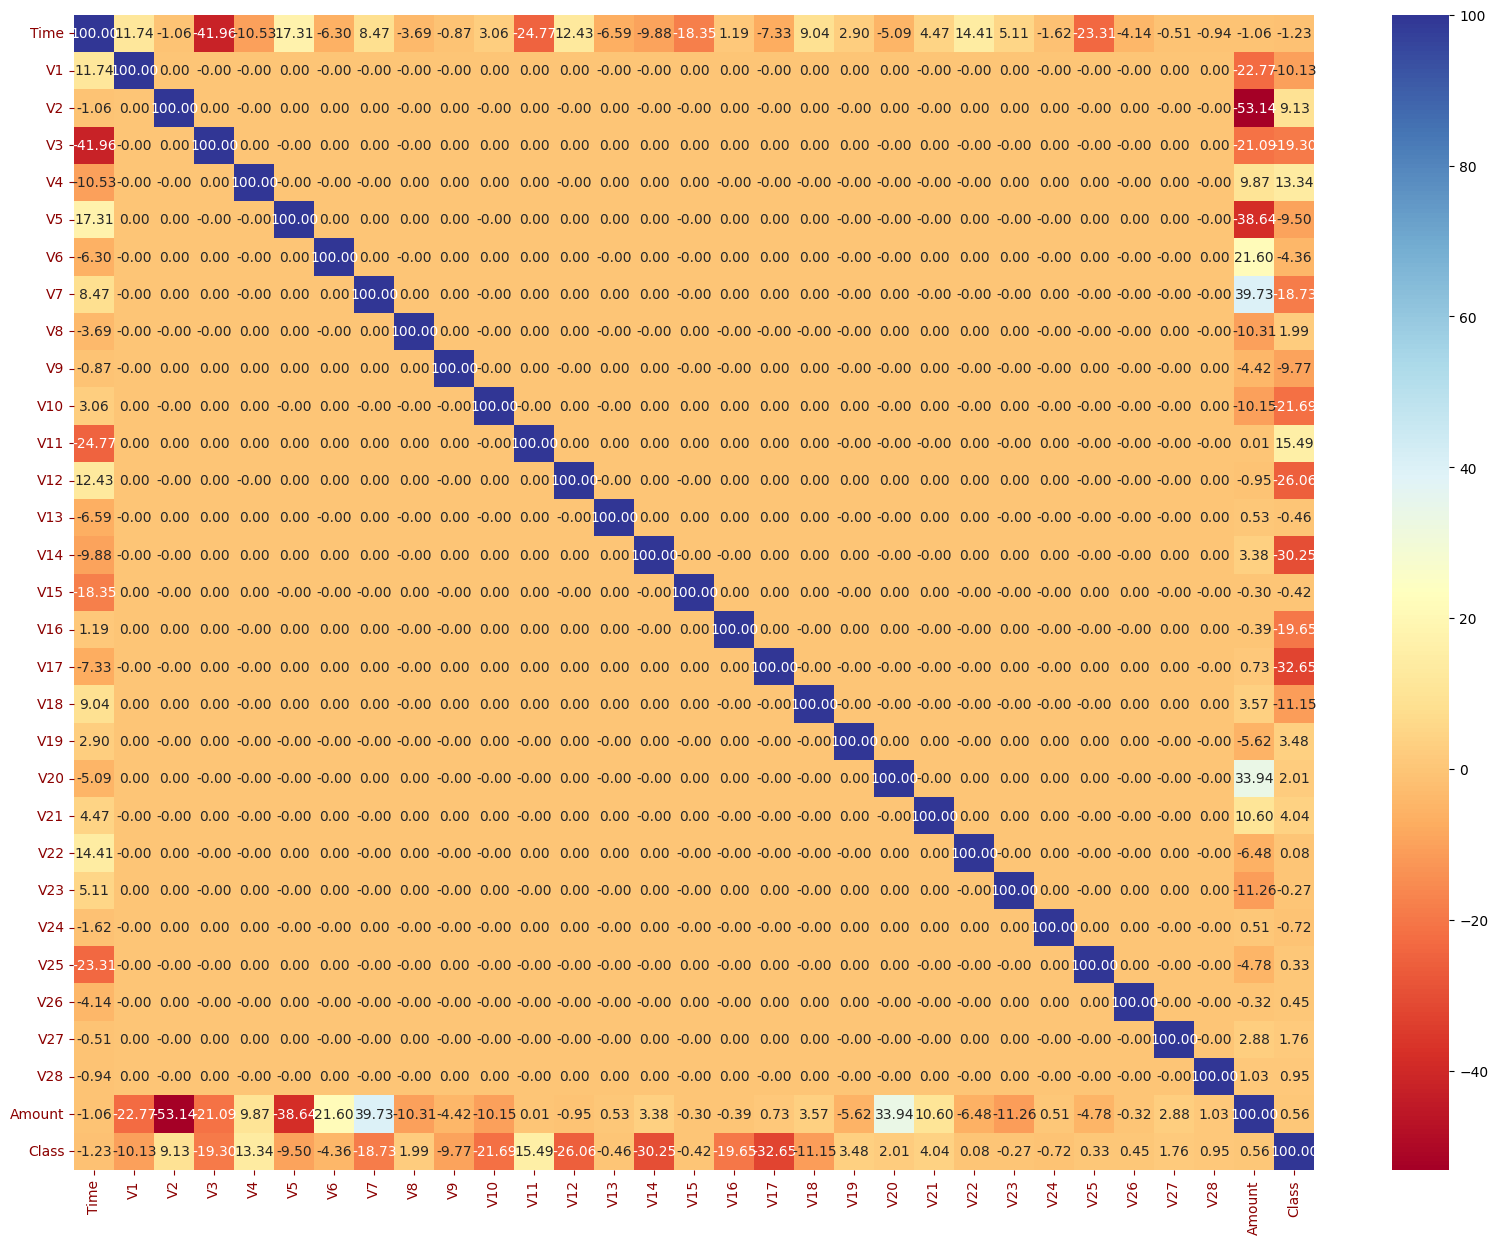

In [10]:
show_corr_heatmap(dataset)

In [11]:
X = np.array(X_df)
y = np.array(y_df).reshape(-1, 1)

In [12]:
# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
_, counts = np.unique(y, return_counts=True)
class_ratio = counts[0]/counts[1]
class_ratio

np.float64(577.8760162601626)

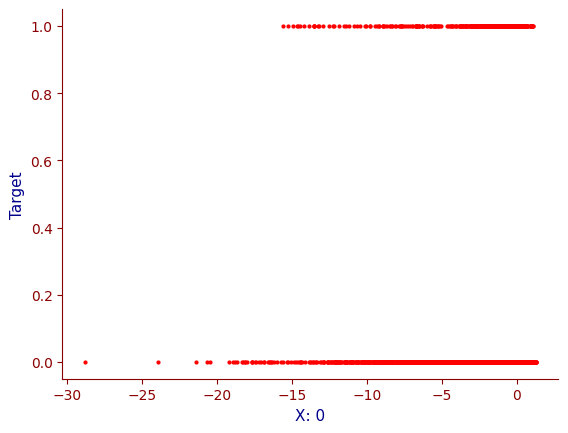

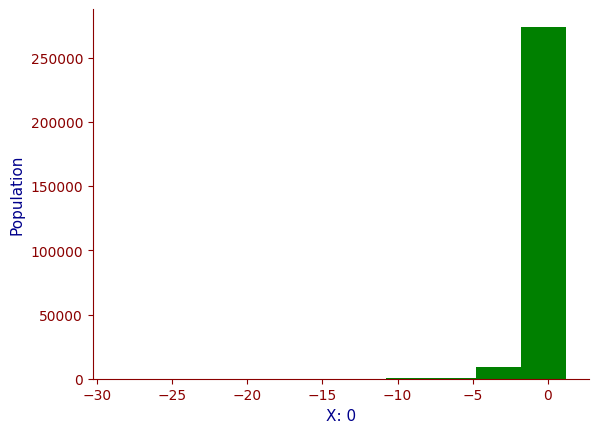

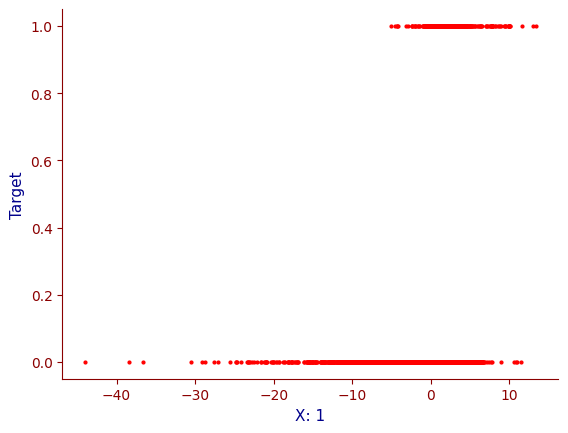

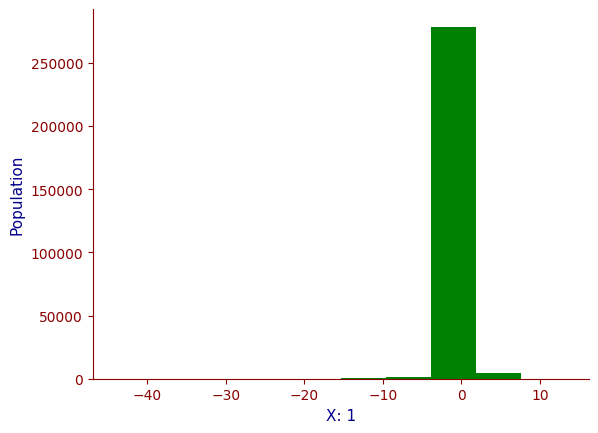

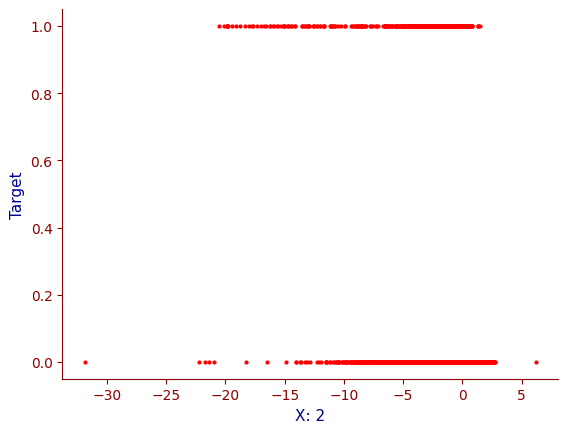

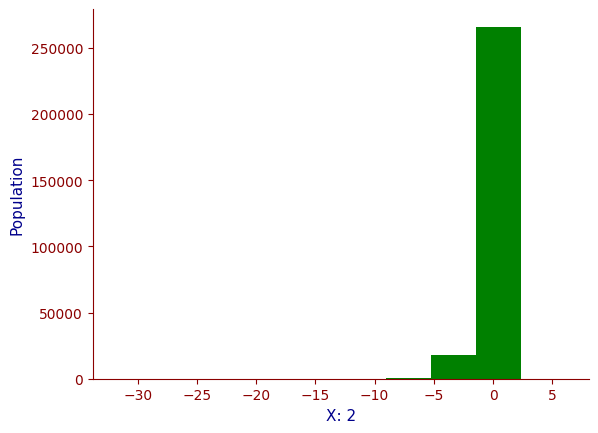

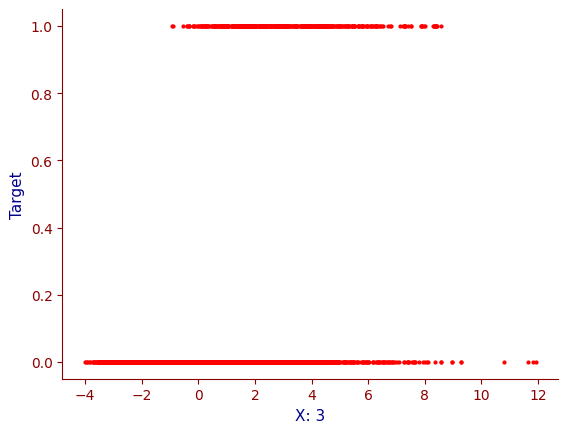

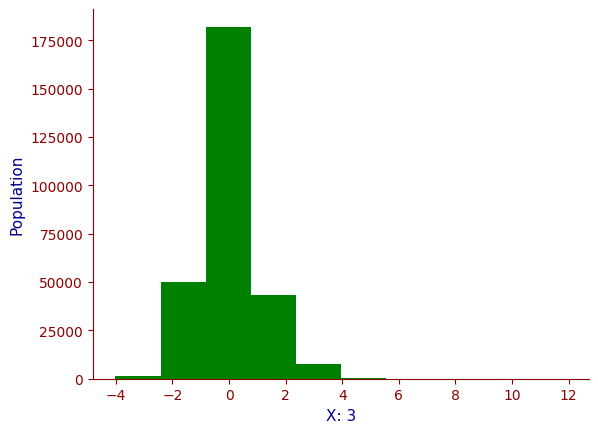

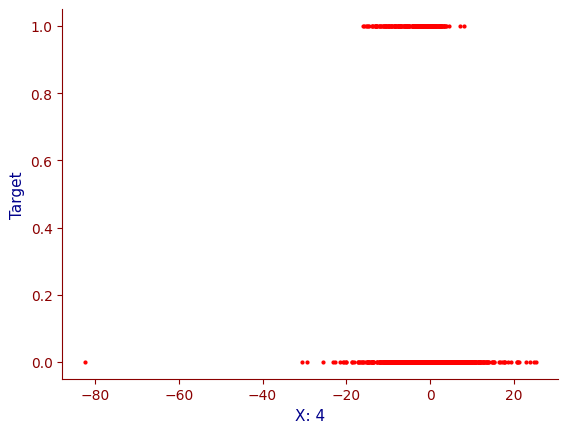

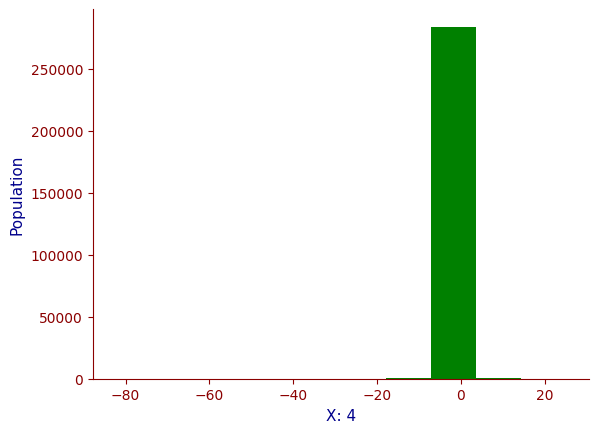

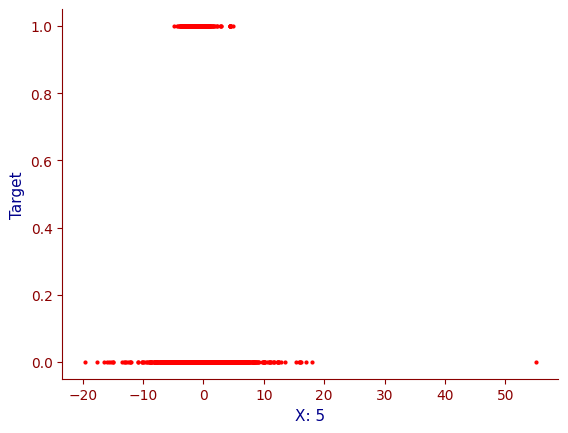

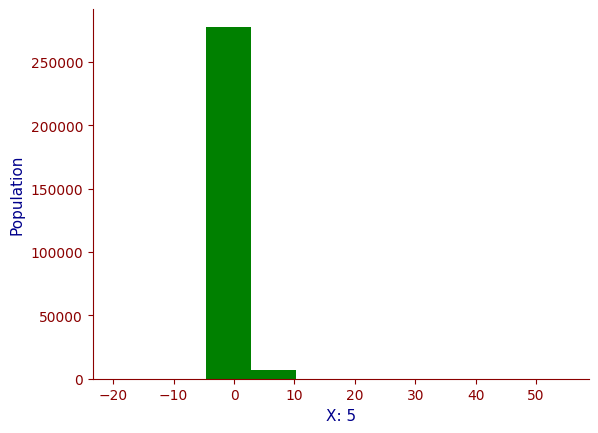

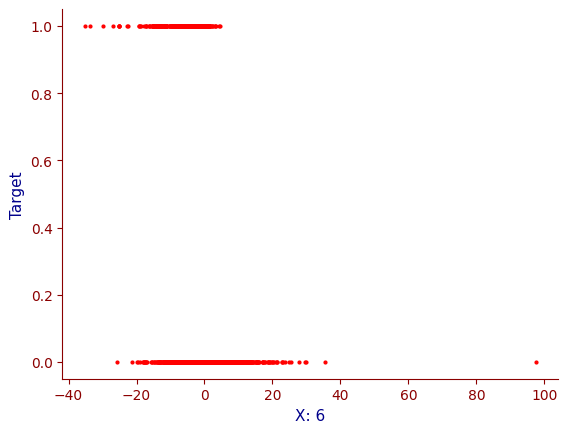

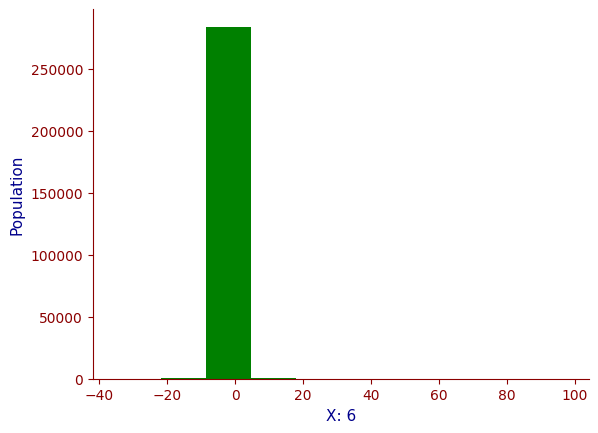

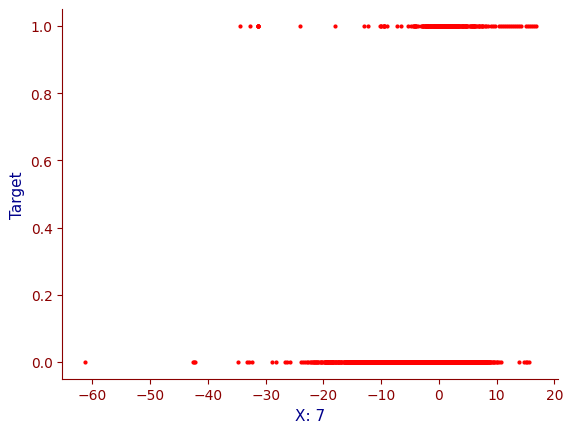

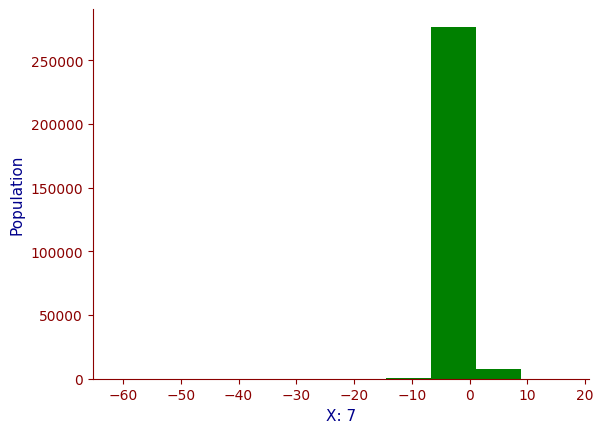

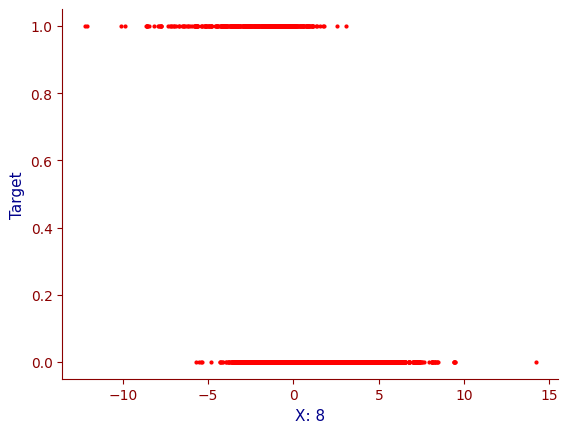

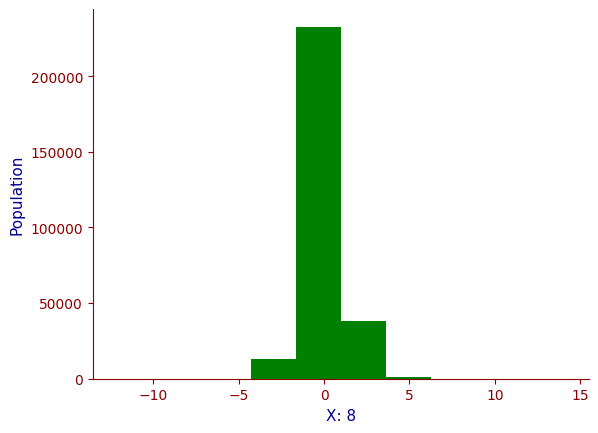

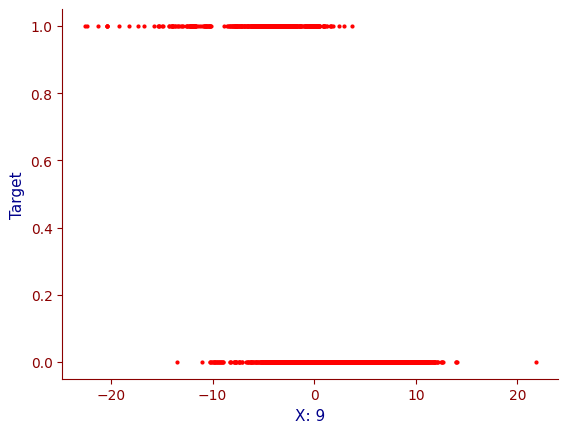

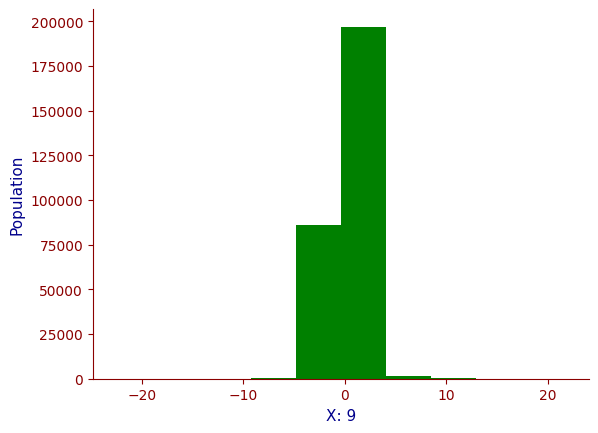

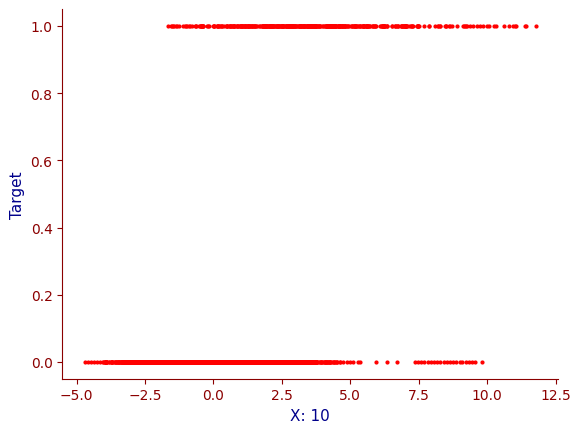

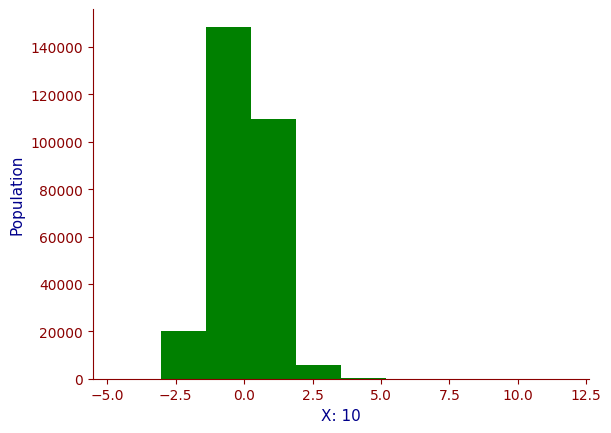

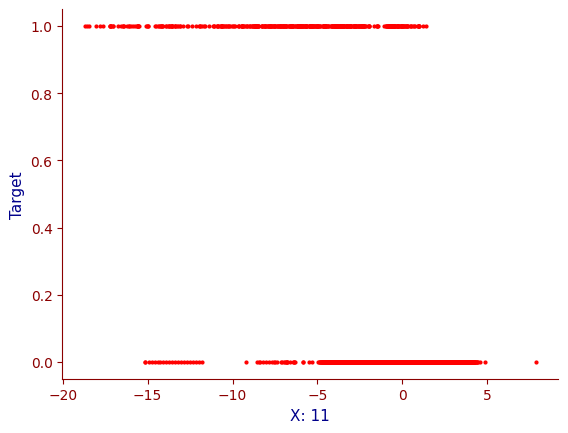

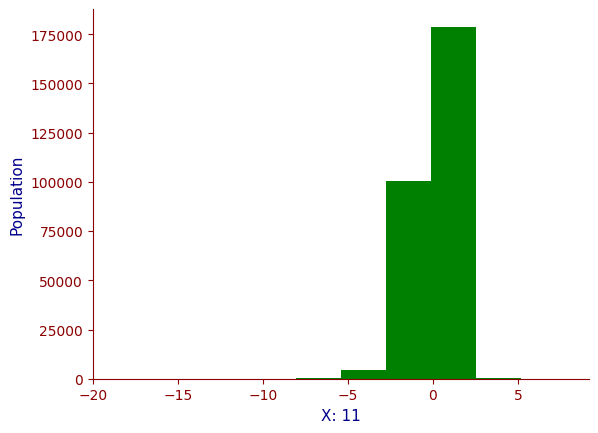

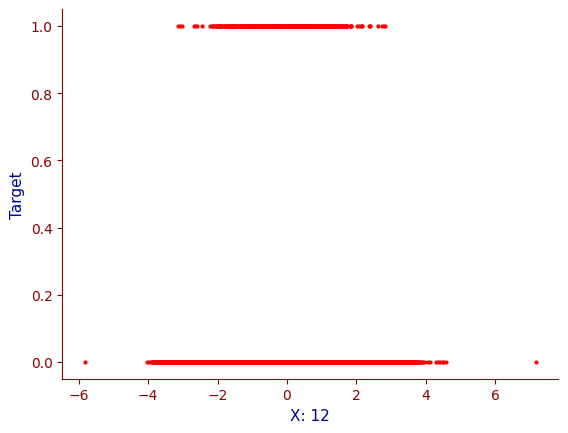

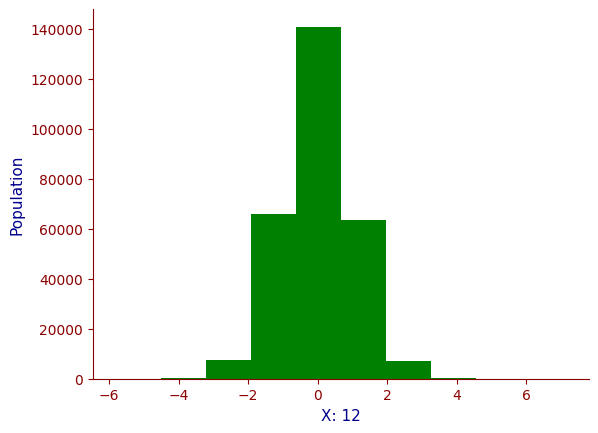

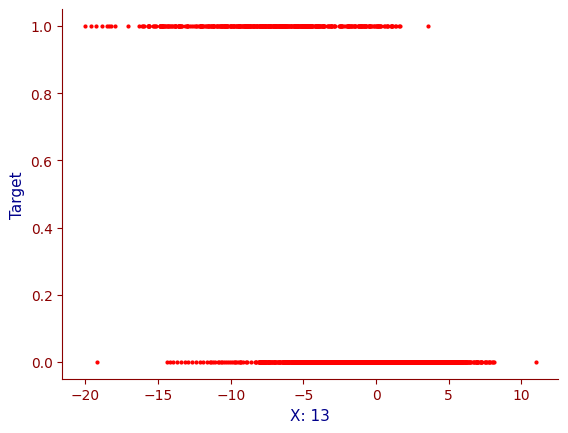

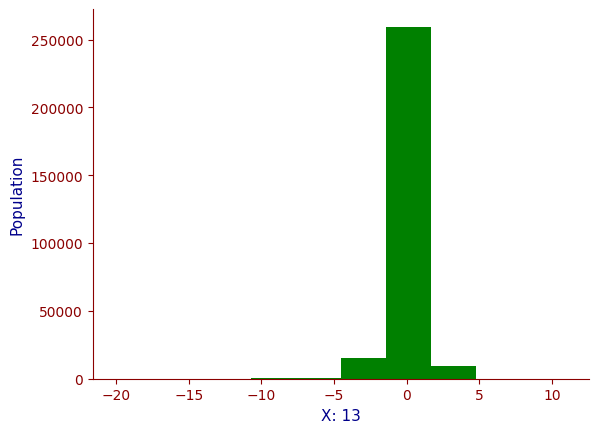

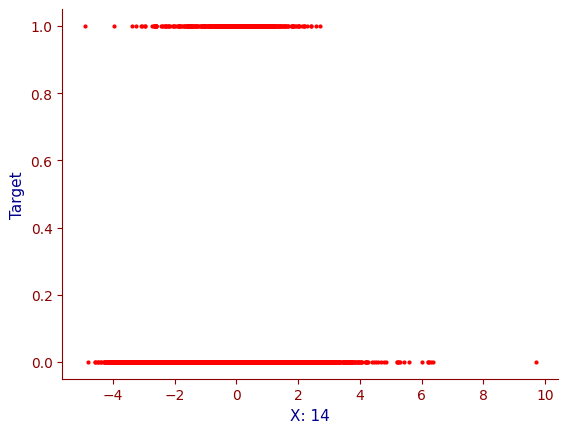

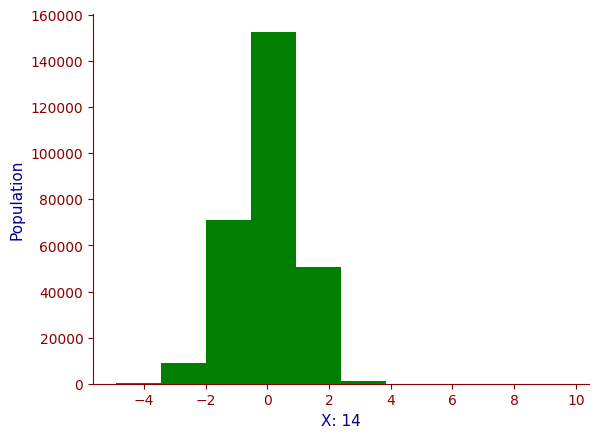

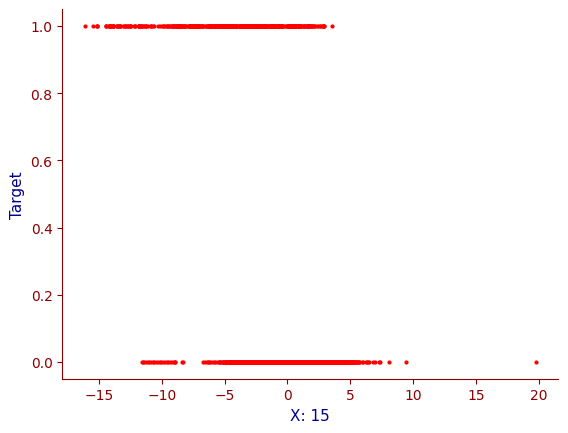

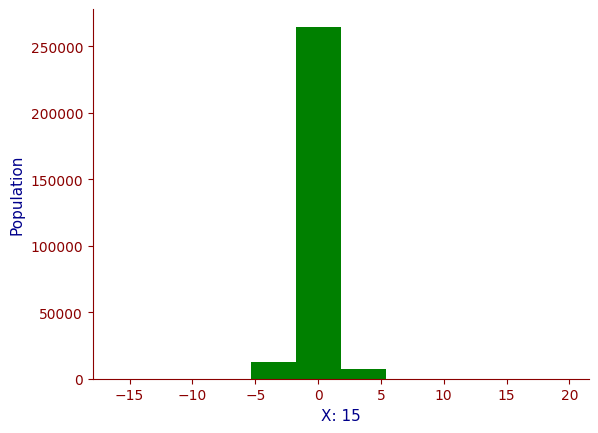

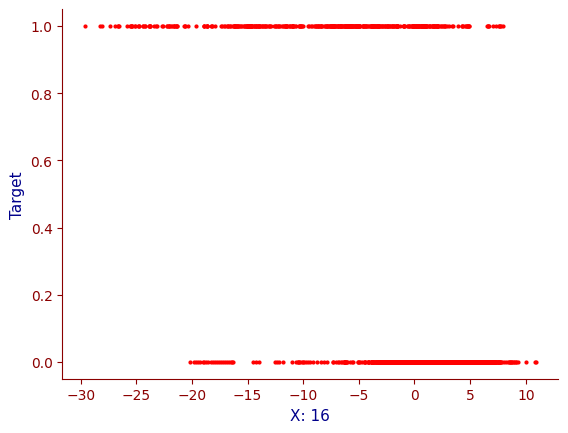

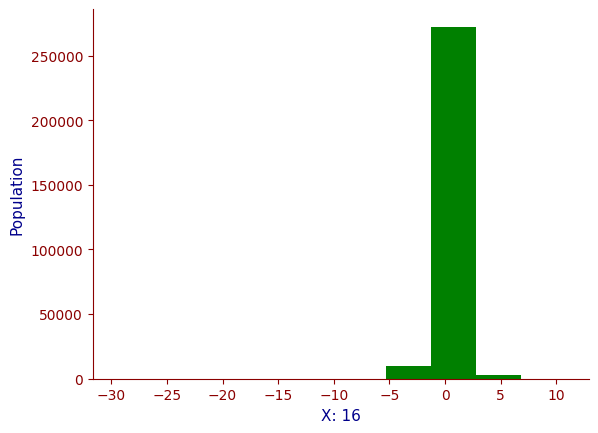

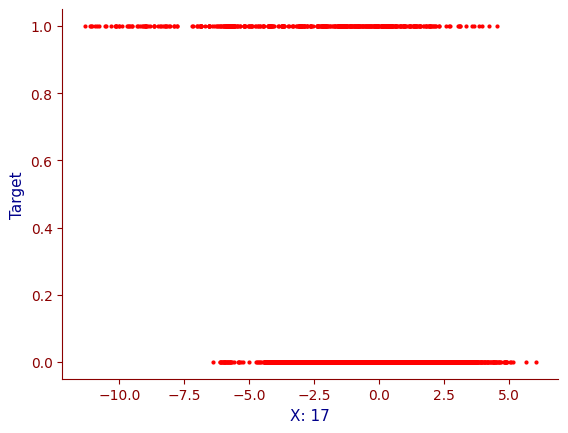

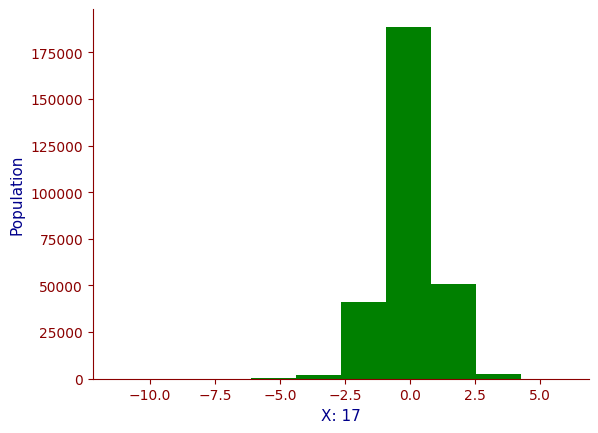

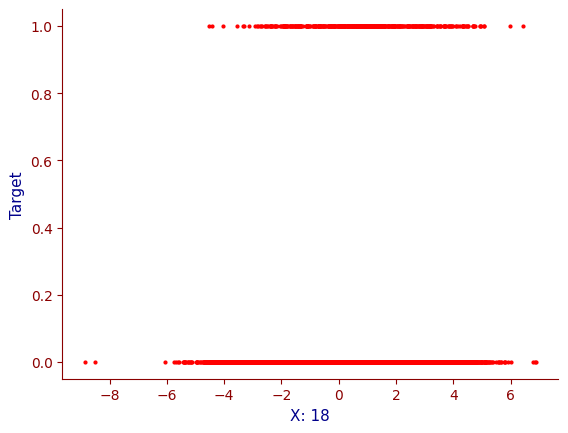

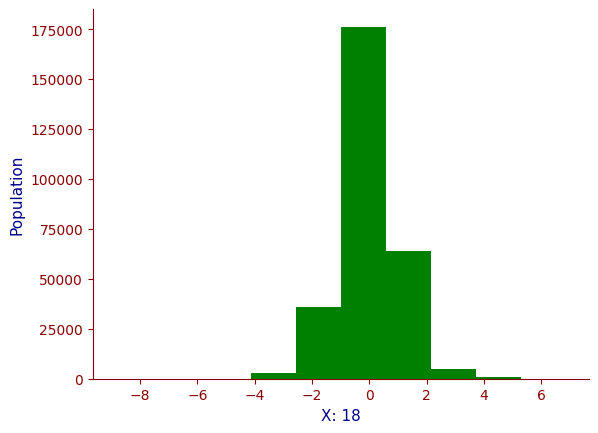

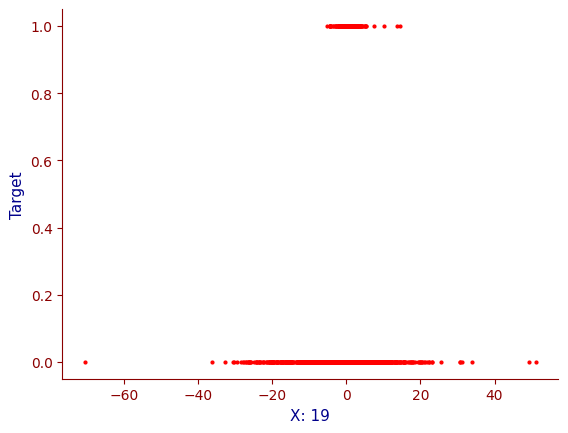

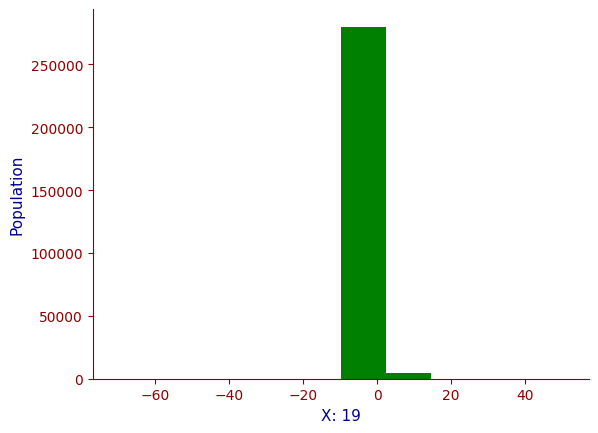

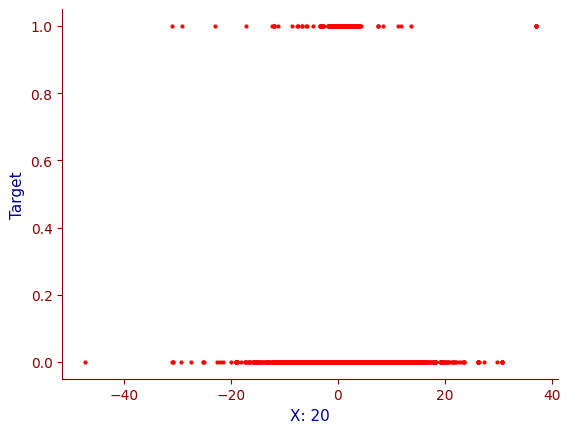

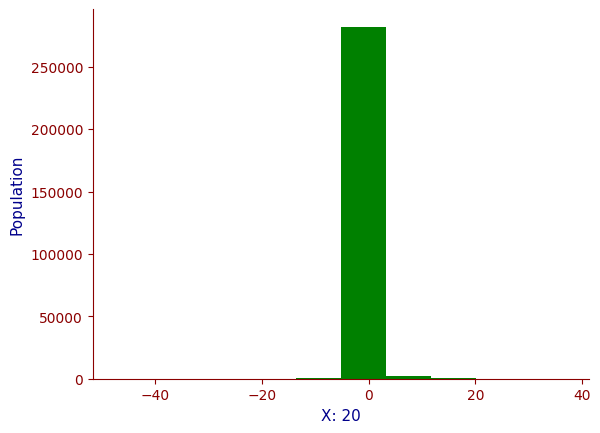

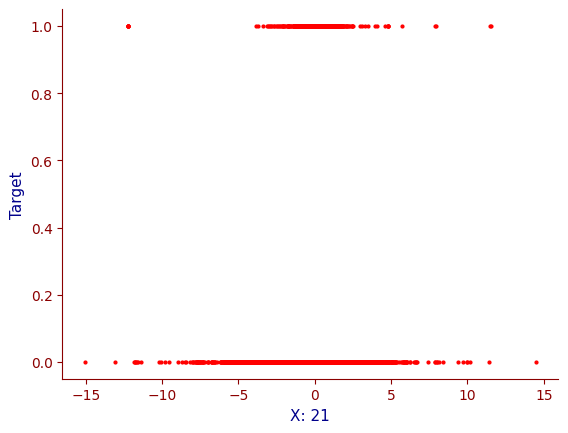

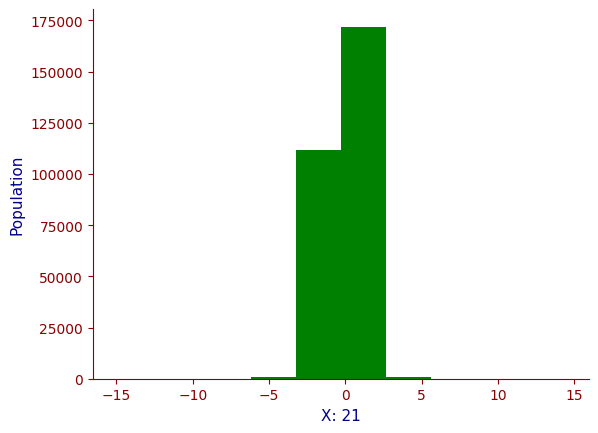

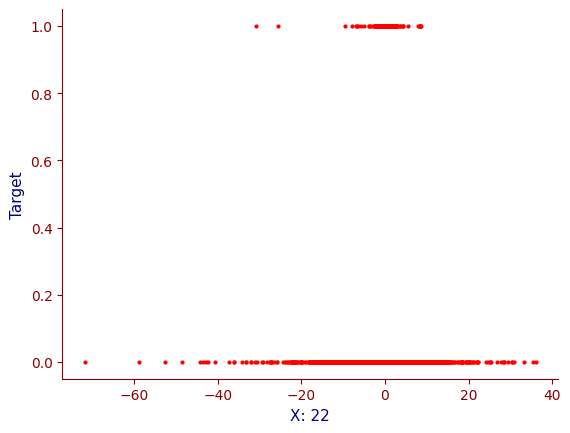

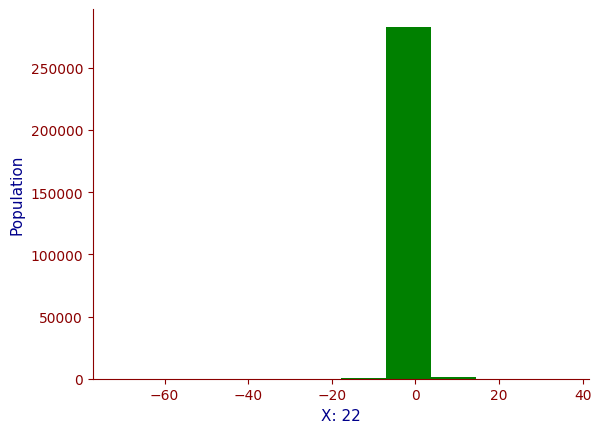

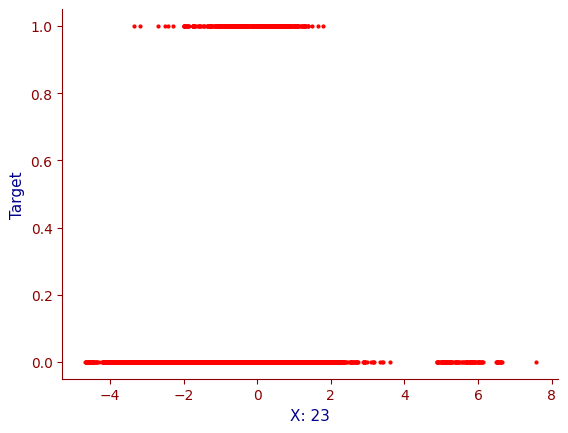

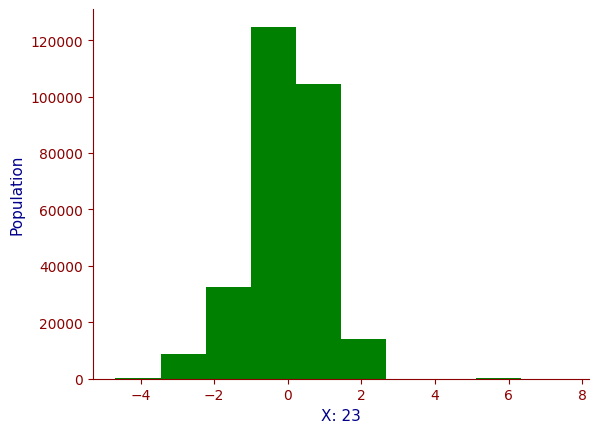

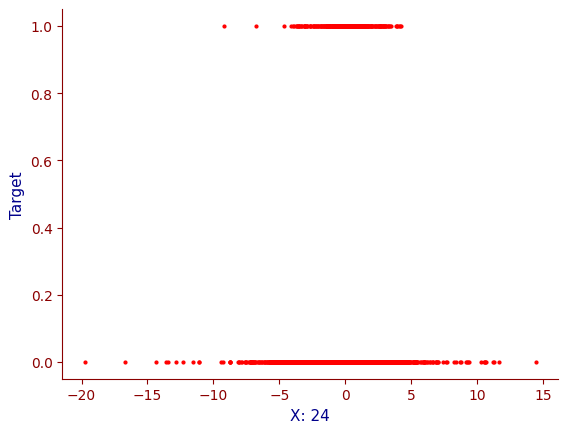

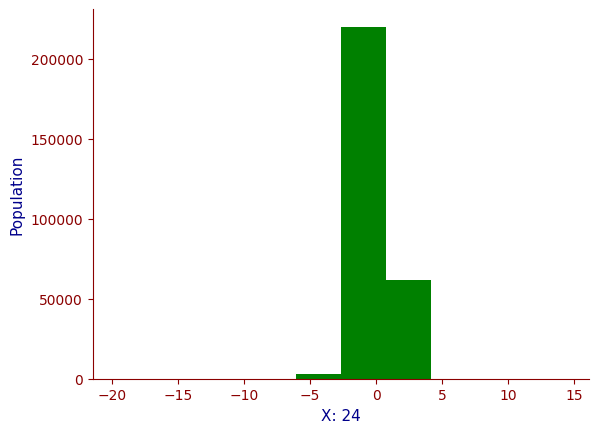

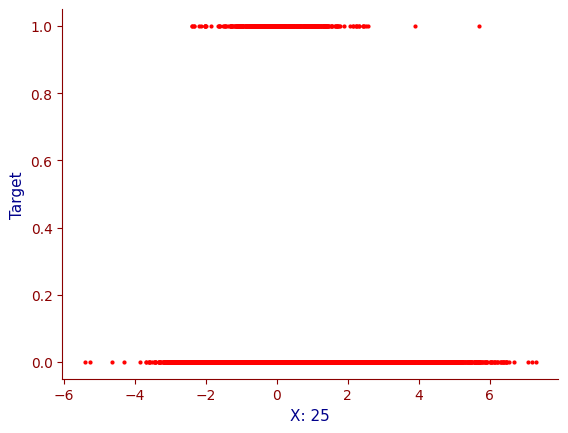

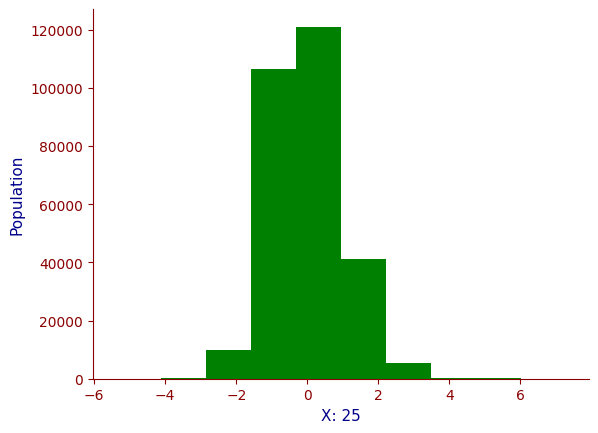

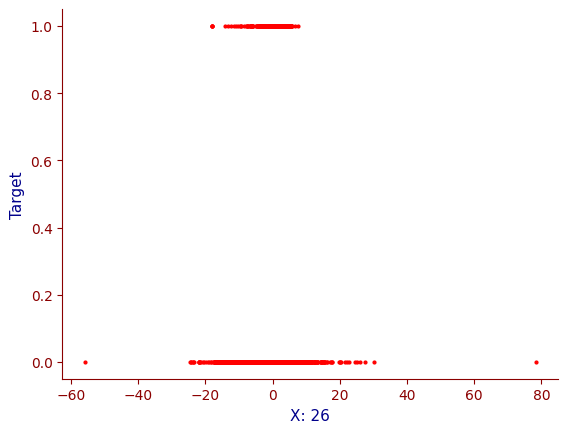

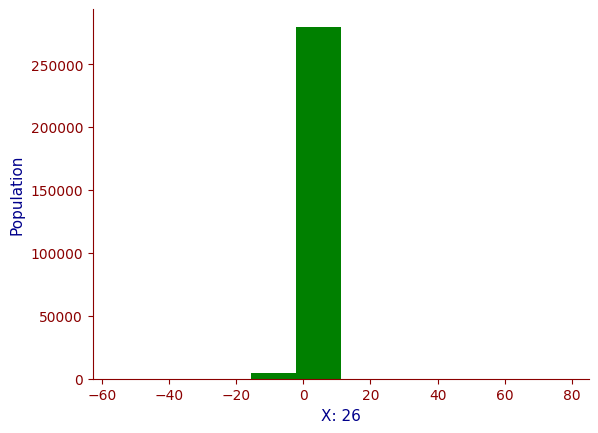

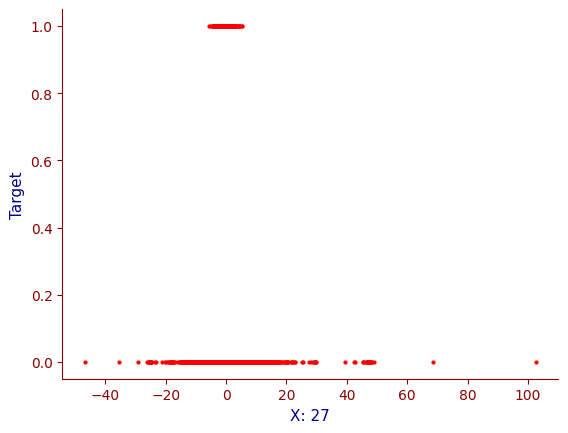

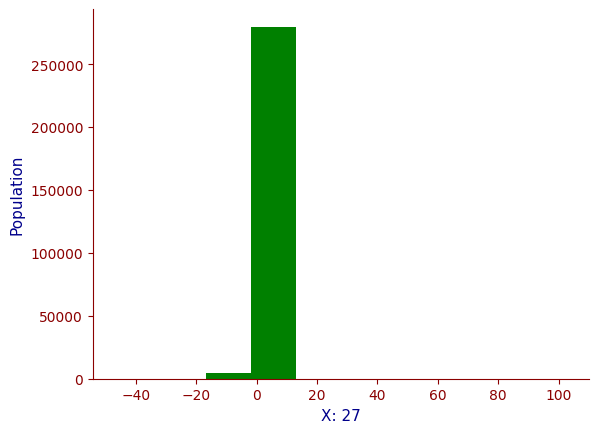

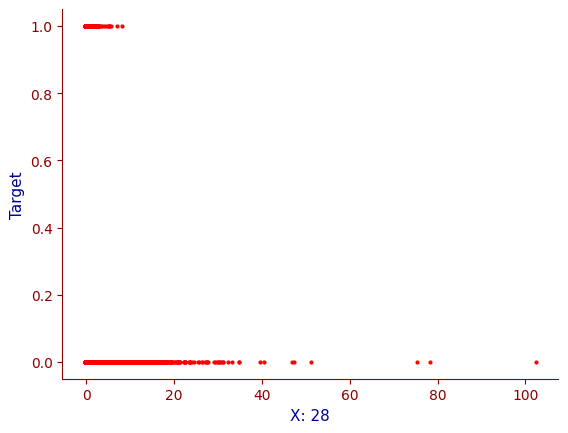

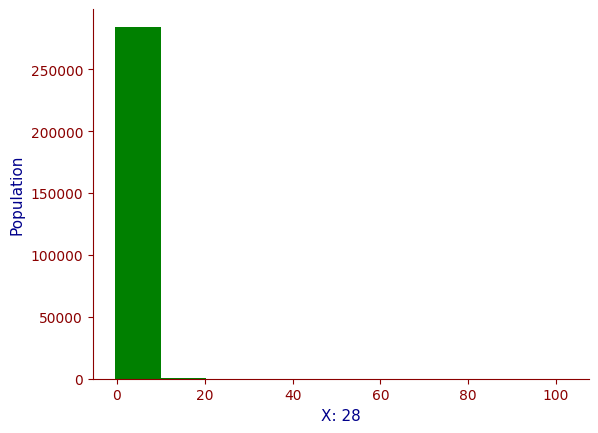

In [14]:
plot_features(X, y)

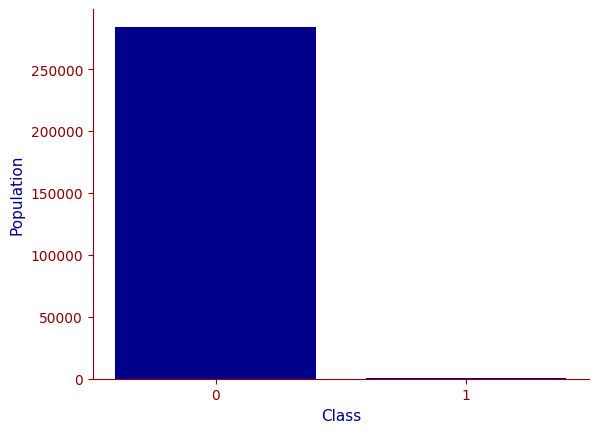

In [15]:
plot_class_dist(y)

In [16]:
X0_train, X0_test, y0_train, y0_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=N_SEED,
    shuffle=True,
    stratify=y
)

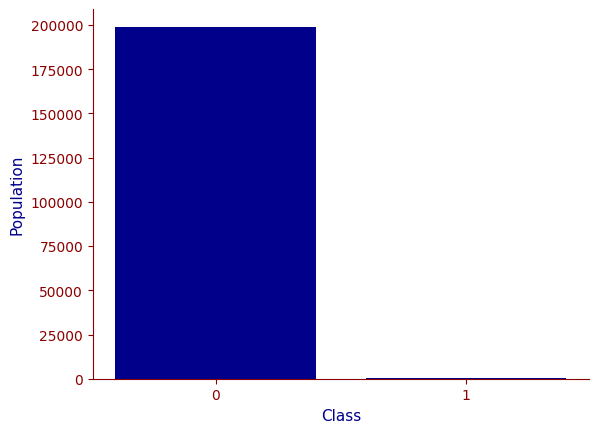

In [17]:
plot_class_dist(y0_train)

## Over Sampling train dataset

In [18]:
smote = SMOTE(
    sampling_strategy="minority",
    k_neighbors=5,
    random_state=N_SEED,
)

X_train, y_train = smote.fit_resample(X0_train, y0_train)
X_test, y_test = X0_test, y0_test

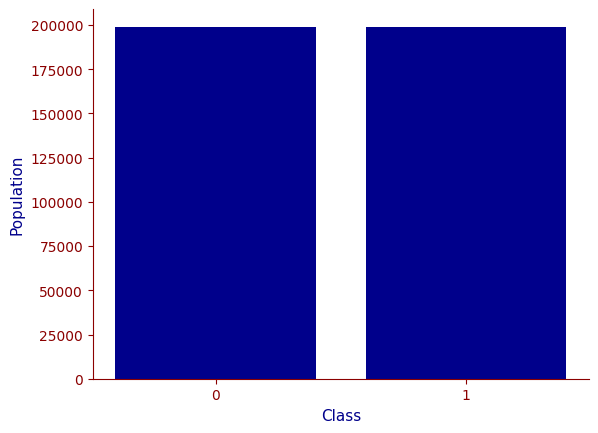

In [19]:
plot_class_dist(y_train)

## Logistic Regression

In [20]:
param_grid_LGR = {
    "solver": ["newton-cholesky"],
    "penalty": ["l2", None],
}

grid_search_cv_LGR = GridSearchCV(
    LogisticRegression(
        n_jobs=N_JOBS,
        random_state=N_SEED,
        verbose=VERBOSE,
    ),
    param_grid=param_grid_LGR,
    refit=True,
)

pipeline_LGR = make_pipeline(
    grid_search_cv_LGR,
)

pipeline_LGR.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=LogisticRegression(n_jobs=4,
                                                           random_state=19,
                                                           verbose=1),
                              param_grid={'penalty': ['l2', None],
                                          'solver': ['newton-cholesky']}))])

In [21]:
grid_search_cv_LGR.cv_results_

{'mean_fit_time': array([1.19023437, 0.81608839]),
 'std_fit_time': array([0.23711498, 0.04388361]),
 'mean_score_time': array([0.0047956 , 0.00432057]),
 'std_score_time': array([0.00083907, 0.00043837]),
 'param_penalty': masked_array(data=['l2', None],
              mask=[False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'param_solver': masked_array(data=['newton-cholesky', 'newton-cholesky'],
              mask=[False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'params': [{'penalty': 'l2', 'solver': 'newton-cholesky'},
  {'penalty': None, 'solver': 'newton-cholesky'}],
 'split0_test_score': array([0.94533213, 0.94533213]),
 'split1_test_score': array([0.94604814, 0.94607326]),
 'split2_test_score': array([0.94462868, 0.9446538 ]),
 'split3_test_score': array([0.94515627, 0.94513114]),
 'split4_test_score': array([0.94611094, 0.94608582]),
 'mean_test_score': array([0.94545523, 0.94545523]),
 'std_test_score': array([0.00056022, 

In [22]:
y_pred_LGR = pipeline_LGR.predict(X_test)
y_prob_LGR = pipeline_LGR.predict_proba(X_test) * 100
cm_LGR = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_LGR)

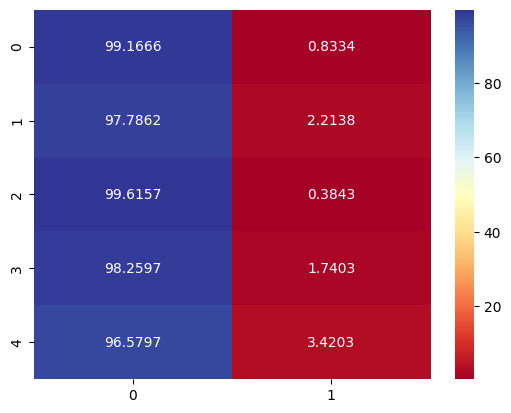

In [23]:
sns.heatmap(y_prob_LGR[:TOP_K], annot=True, cmap=COLOR_MAP, fmt=".4f");

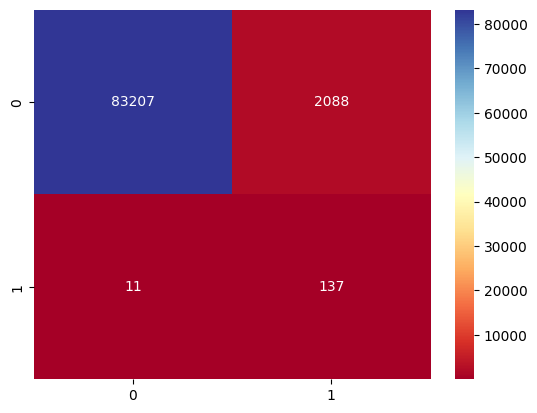

In [24]:
sns.heatmap(cm_LGR, annot=True, cmap=COLOR_MAP, fmt=".0f");

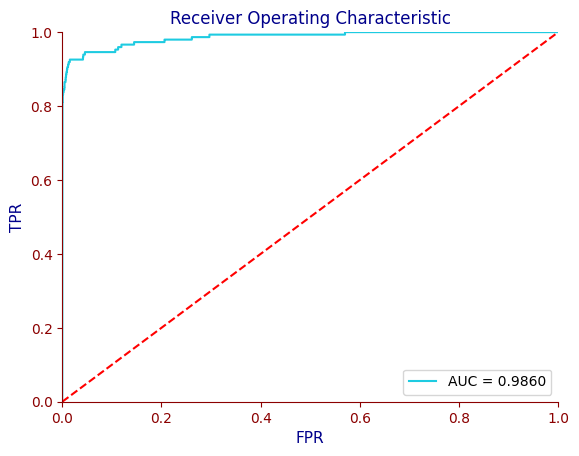

In [25]:
fpr_LGR, tpr_LGR, _ = metrics.roc_curve(y_test, y_prob_LGR[:, 1])
roc_auc_LGR = metrics.auc(fpr_LGR, tpr_LGR)
plot_roc(fpr_LGR, tpr_LGR, roc_auc_LGR)

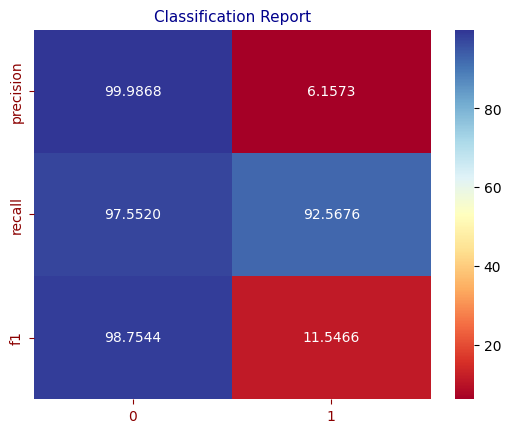

In [26]:
plot_classification(y_true=y_test, y_pred=y_pred_LGR)

In [27]:
metrics.accuracy_score(y_true=y_test, y_pred=y_pred_LGR)

0.975433915007666

## Random Forest Classifier

In [28]:
param_grid_RFC = {
}

grid_search_cv_RFC = GridSearchCV(
    RandomForestClassifier(
        n_jobs=N_JOBS,
        random_state=N_SEED,
        verbose=VERBOSE,
    ),
    param_grid=param_grid_RFC,
    refit=True,
)

pipeline_RFC = make_pipeline(
    grid_search_cv_RFC,
)

pipeline_RFC.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   48.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   46.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.9s
[Parallel(n_job

Newton iter=1
  Check Convergence
    1. max |gradient| 0.6091618641626071 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 0.25479446449639814 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 0.10541156386930614 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 0.045473123504368225 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 0.02045942371471513 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.008807957158301702 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 0.004010306723626382 <= 0.0001
Newton iter=8
  Check Convergence
    1. max |gradient| 0.0020051397600400612 <= 0.0001
Newton iter=9
  Check Convergence
    1. max |gradient| 0.0007633255889075372 <= 0.0001
Newton iter=10
  Check Convergence
    1. max |gradient| 0.00017823910042384368 <= 0.0001
Newton iter=11
  Check Convergence
    1. max |gradient| 1.855822738160528e-05 <= 0.0001
    2. Newton decrement 6.858924186945152

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.1min finished


Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=RandomForestClassifier(n_jobs=4,
                                                               random_state=19,
                                                               verbose=1),
                              param_grid={}))])

In [29]:
grid_search_cv_RFC.cv_results_

{'mean_fit_time': array([48.250348]),
 'std_fit_time': array([1.07247611]),
 'mean_score_time': array([0.10577917]),
 'std_score_time': array([0.00436564]),
 'params': [{}],
 'split0_test_score': array([0.99993719]),
 'split1_test_score': array([0.99987438]),
 'split2_test_score': array([0.99989951]),
 'split3_test_score': array([0.99992463]),
 'split4_test_score': array([0.99978645]),
 'mean_test_score': array([0.99988443]),
 'std_test_score': array([5.35304888e-05]),
 'rank_test_score': array([1], dtype=int32)}

In [30]:
y_pred_RFC = pipeline_RFC.predict(X_test)
y_prob_RFC = pipeline_RFC.predict_proba(X_test) * 100
cm_RFC = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_RFC)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


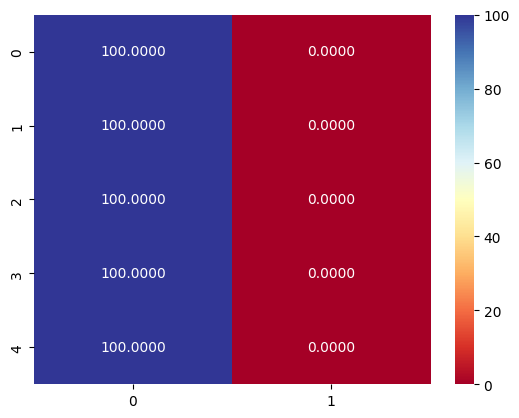

In [31]:
sns.heatmap(y_prob_RFC[:TOP_K], annot=True, cmap=COLOR_MAP, fmt=".4f");

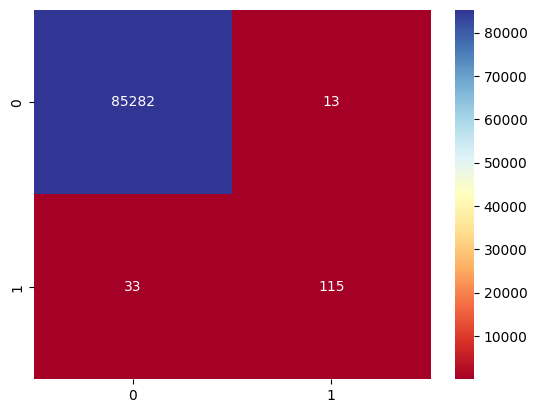

In [32]:
sns.heatmap(cm_RFC, annot=True, cmap=COLOR_MAP, fmt=".0f");

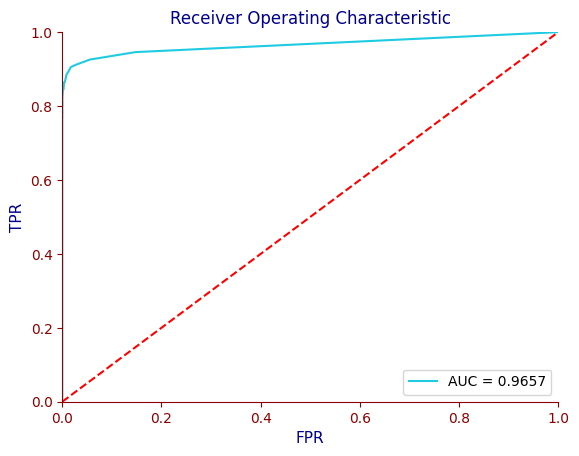

In [33]:
fpr_RFC, tpr_RFC, _ = metrics.roc_curve(y_test, y_prob_RFC[:, 1])
roc_auc_RFC = metrics.auc(fpr_RFC, tpr_RFC)
plot_roc(fpr_RFC, tpr_RFC, roc_auc_RFC)

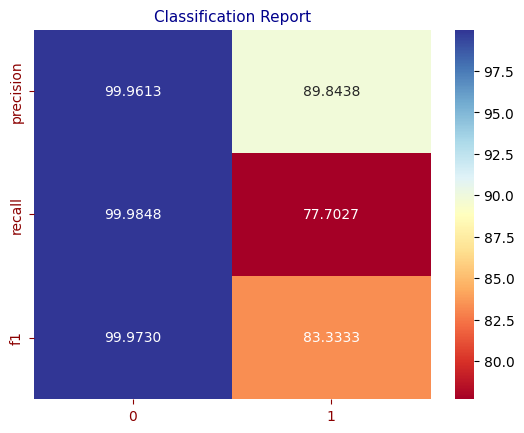

In [34]:
plot_classification(y_true=y_test, y_pred=y_pred_RFC)

In [35]:
metrics.accuracy_score(y_true=y_test, y_pred=y_pred_RFC)

0.9994616293903538

## XGBoost

In [36]:
params_XGB = {
    "n_jobs": N_JOBS,
    "verbosity": VERBOSE,
}

param_grid_XGB = {
    "eta": [0.3, 0.5],
    "max_depth": [6, 8, 10]
}

model_XGB = XGBClassifier(**params_XGB)

grid_search_cv_XGB = GridSearchCV(
    model_XGB,
    param_grid=param_grid_XGB,
    refit=True,
)

pipeline_XGB = make_pipeline(
    grid_search_cv_XGB,
)

pipeline_XGB.fit(X_train, y_train)

Pipeline(steps=[('gridsearchcv',
                 GridSearchCV(estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=4,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              param_grid={'eta': [0.3, 0.5],
                                          'max_depth': [6, 8, 10]}))])

In [37]:
grid_search_cv_XGB.cv_results_

{'mean_fit_time': array([1.03143711, 1.14465761, 1.2278626 , 1.04812603, 1.10860558,
        1.11442389]),
 'std_fit_time': array([0.02430869, 0.01004848, 0.01171611, 0.0257883 , 0.03091106,
        0.02620797]),
 'mean_score_time': array([0.03878417, 0.07278814, 0.09597435, 0.0463902 , 0.07343006,
        0.0824441 ]),
 'std_score_time': array([0.00072164, 0.00215076, 0.00526418, 0.00065476, 0.00167218,
        0.00134056]),
 'param_eta': masked_array(data=[0.3, 0.3, 0.3, 0.5, 0.5, 0.5],
              mask=[False, False, False, False, False, False],
        fill_value=1e+20),
 'param_max_depth': masked_array(data=[6, 8, 10, 6, 8, 10],
              mask=[False, False, False, False, False, False],
        fill_value=999999),
 'params': [{'eta': 0.3, 'max_depth': 6},
  {'eta': 0.3, 'max_depth': 8},
  {'eta': 0.3, 'max_depth': 10},
  {'eta': 0.5, 'max_depth': 6},
  {'eta': 0.5, 'max_depth': 8},
  {'eta': 0.5, 'max_depth': 10}],
 'split0_test_score': array([0.9998367 , 0.99987438, 0.99991

In [38]:
y_pred_XGB = pipeline_XGB.predict(X_test)
y_prob_XGB = pipeline_XGB.predict_proba(X_test) * 100
cm_XGB = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_XGB)

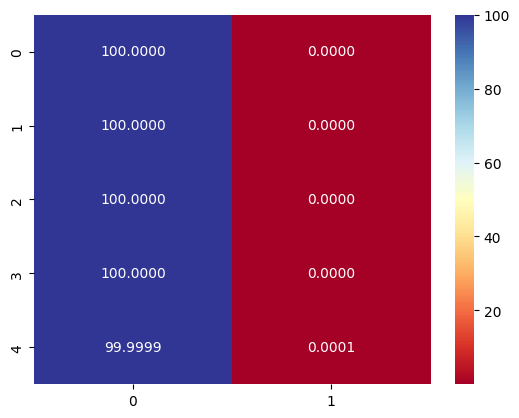

In [39]:
sns.heatmap(y_prob_XGB[:TOP_K], annot=True, cmap=COLOR_MAP, fmt=".4f");

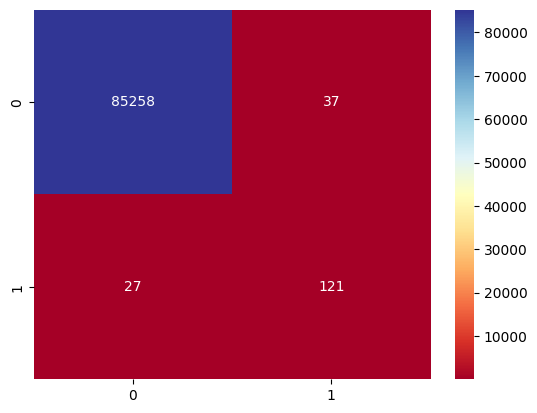

In [40]:
sns.heatmap(cm_XGB, annot=True, cmap=COLOR_MAP, fmt=".0f");

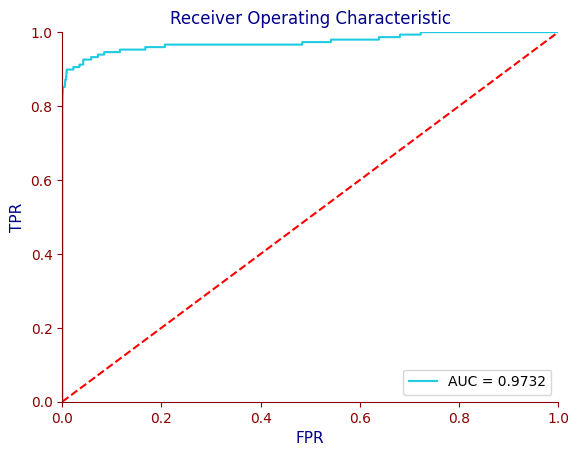

In [41]:
fpr_XGB, tpr_XGB, _ = metrics.roc_curve(y_test, y_prob_XGB[:, 1])
roc_auc_XGB = metrics.auc(fpr_XGB, tpr_XGB)
plot_roc(fpr_XGB, tpr_XGB, roc_auc_XGB)

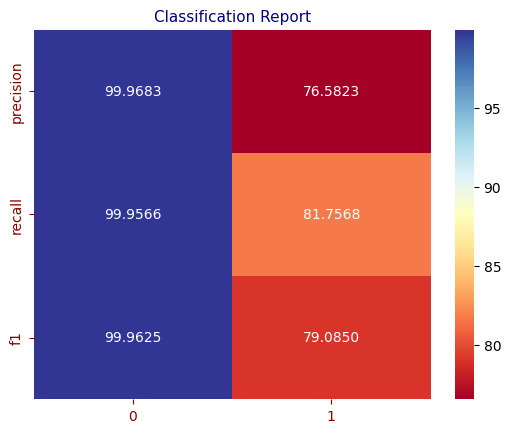

In [42]:
plot_classification(y_true=y_test, y_pred=y_pred_XGB)

In [43]:
metrics.accuracy_score(y_true=y_test, y_pred=y_pred_XGB)

0.9992509626300574